In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style = "whitegrid")
sns.set_palette("icefire")
pd.set_option('display.max_columns', 500)

# Load Data

In [2]:
patient = joblib.load("patient.pkl")

In [3]:
print(patient.shape)
patient.head()

(558211, 56)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,IsOutpatient,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092,NaN,NaN,NaN,NaN,NaN,0,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331,NaN,NaN,NaN,NaN,NaN,0,1914-03-01,NaT,0,2,0,1,360,12,12,0,1,1,0,0,1,1,0,0,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893,NaN,NaN,NaN,NaN,NaN,0,1938-04-01,NaT,0,1,1,45,780,12,12,0,1,1,0,1,1,0,1,0,0,0,21260,2136,120,100,No


## How many medical doctors are there in the train outpatient dataset?

In [6]:
print("Physician Count for Outpaitents")
print("Attending Physician:", patient[patient["IsOutpatient"] == 1]["AttendingPhysician"].count())
print("Operating Physician:", patient[patient["IsOutpatient"] == 1]["OperatingPhysician"].count())
print("Other Physician:", patient[patient["IsOutpatient"] == 1]["OtherPhysician"].count())

Physician Count for Outpaitents
Attending Physician: 516341
Operating Physician: 90617
Other Physician: 195046


## How many medical doctors are there in the train inpatient dataset? Do they match with those from the outpatient record?

In [7]:
print("Physician Count for Inpaitents")
print("Attending Physician:", patient[patient["IsOutpatient"] == 0]["AttendingPhysician"].count())
print("Operating Physician:", patient[patient["IsOutpatient"] == 0]["OperatingPhysician"].count())
print("Other Physician:", patient[patient["IsOutpatient"] == 0]["OtherPhysician"].count())

Physician Count for Inpaitents
Attending Physician: 40362
Operating Physician: 23830
Other Physician: 4690


## Do those inpatient patients show worse health conditions (in terms of chronic diseases) than typical outpatient patients?

In [8]:
chronic = patient.columns[patient.columns.str.contains("Chronic")].tolist()
print("Percentage of inpatients with certain chronic disease")
patient[patient["IsOutpatient"] == 0][chronic].sum()/(patient[patient["IsOutpatient"] == 0].shape[0])

Percentage of inpatients with certain chronic disease


ChronicCond_Alzheimer              0.504052
ChronicCond_Heartfailure           0.721821
ChronicCond_KidneyDisease          0.601769
ChronicCond_Cancer                 0.190962
ChronicCond_ObstrPulmonary         0.479147
ChronicCond_Depression             0.502224
ChronicCond_Diabetes               0.802046
ChronicCond_IschemicHeart          0.856698
ChronicCond_Osteoporasis           0.351559
ChronicCond_rheumatoidarthritis    0.360355
ChronicCond_stroke                 0.169837
dtype: float64

In [9]:
print("Percentage of outpatients with certain chronic disease")
patient[patient["IsOutpatient"] == 1][chronic].sum()/(patient[patient["IsOutpatient"] == 1].shape[0])

Percentage of outpatients with certain chronic disease


ChronicCond_Alzheimer              0.393880
ChronicCond_Heartfailure           0.580156
ChronicCond_KidneyDisease          0.397167
ChronicCond_Cancer                 0.148292
ChronicCond_ObstrPulmonary         0.299936
ChronicCond_Depression             0.429537
ChronicCond_Diabetes               0.697839
ChronicCond_IschemicHeart          0.751648
ChronicCond_Osteoporasis           0.314996
ChronicCond_rheumatoidarthritis    0.307326
ChronicCond_stroke                 0.096395
dtype: float64

## or do those who have more visits to the providers have worse health conditions?

In [11]:
xx = patient.groupby('BeneID').count().ClaimID.reset_index()
bene_more = xx[xx.ClaimID > 1].BeneID.tolist()

In [12]:
print("Patients who visited the hospital more than once")
patient[patient["BeneID"].isin(bene_more)][chronic].sum()/(patient[patient["BeneID"].isin(bene_more)].shape[0])

Patients who visited the hospital more than once


ChronicCond_Alzheimer              0.412986
ChronicCond_Heartfailure           0.606022
ChronicCond_KidneyDisease          0.426724
ChronicCond_Cancer                 0.156361
ChronicCond_ObstrPulmonary         0.324514
ChronicCond_Depression             0.447159
ChronicCond_Diabetes               0.723132
ChronicCond_IschemicHeart          0.774370
ChronicCond_Osteoporasis           0.325096
ChronicCond_rheumatoidarthritis    0.320488
ChronicCond_stroke                 0.105220
dtype: float64

In [13]:
print("Patients who visited the hospital only once")
patient[~patient["BeneID"].isin(bene_more)][chronic].sum()/(patient[~patient["BeneID"].isin(bene_more)].shape[0])

Patients who visited the hospital only once


ChronicCond_Alzheimer              0.224189
ChronicCond_Heartfailure           0.341212
ChronicCond_KidneyDisease          0.176735
ChronicCond_Cancer                 0.071881
ChronicCond_ObstrPulmonary         0.127821
ChronicCond_Depression             0.237422
ChronicCond_Diabetes               0.421944
ChronicCond_IschemicHeart          0.517886
ChronicCond_Osteoporasis           0.198607
ChronicCond_rheumatoidarthritis    0.162286
ChronicCond_stroke                 0.045781
dtype: float64

## How many distinct patients (BeneIDs) are there in the in/out-patient datasets?


In [14]:
print("Inpatient unique beneficiaries:", patient[patient["IsOutpatient"] == 0]["BeneID"].nunique())
print("Outpatient unique beneficiaries:", patient[patient["IsOutpatient"] == 1]["BeneID"].nunique())

Inpatient unique beneficiaries: 31289
Outpatient unique beneficiaries: 133980


## Do doctors serve for different providers? Study the distribution of hospital counts/doctor? Is it possible to characterize those doctors who move around among different providers?


In [30]:
patient.groupby('AttendingPhysician')["Provider"].count().describe()

count    82063.000000
mean         6.783849
std         29.907658
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       2534.000000
Name: Provider, dtype: float64

In [31]:
patient.groupby('OperatingPhysician')["Provider"].count().describe()

count    35315.000000
mean         3.240748
std          8.812700
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        424.000000
Name: Provider, dtype: float64

In [32]:
patient.groupby('OtherPhysician')["Provider"].count().describe()

count    46457.000000
mean         4.299374
std         19.218763
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1247.000000
Name: Provider, dtype: float64

In [39]:
# Finding patterns of attending physicians who move around more than 4 hospitals
xx = patient.groupby('AttendingPhysician')["Provider"].count().reset_index()
phy_more = xx[xx.Provider > 4].AttendingPhysician.tolist()

In [47]:
patient.loc[patient["AttendingPhysician"].isin(phy_more),"Att_Phy_Mult"] = 1
patient.loc[~patient["AttendingPhysician"].isin(phy_more),"Att_Phy_Mult"] = 0

In [54]:
num_attphy = patient.groupby(['PotentialFraud','IsOutpatient','Provider'])[['Att_Phy_Mult']].sum()
num_attphy.columns.values[0] = 'NumAttPhyMult'
num_attphy = pd.DataFrame(num_attphy).reset_index()
num_attphy

,PotentialFraud,IsOutpatient,Provider,NumAttPhyMult
0,No,0,PRV51001,0.0
1,No,0,PRV51007,0.0
2,No,0,PRV51008,0.0
3,No,0,PRV51011,0.0
4,No,0,PRV51023,6.0
...,...,...,...,...
7099,Yes,1,PRV57569,33.0
7100,Yes,1,PRV57642,132.0
7101,Yes,1,PRV57672,424.0
7102,Yes,1,PRV57697,2.0


Text(0.5, 1.0, 'Number of Attending Physician Jumping Around for Onpaitents by Providers')

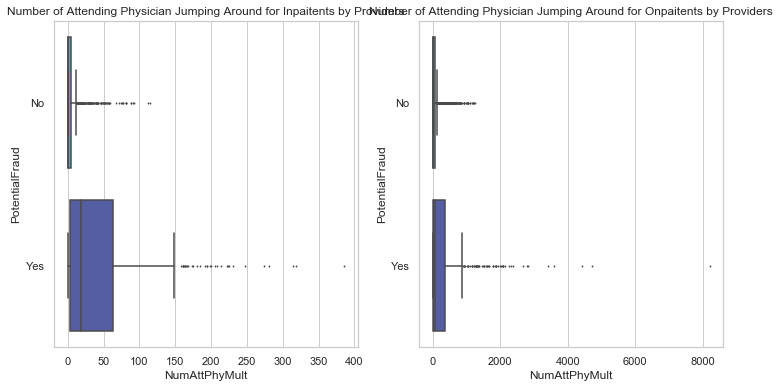

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data = num_attphy[num_attphy['IsOutpatient'] == 0], 
            x = "NumAttPhyMult", y = 'PotentialFraud', ax = ax[0], fliersize= 1);
sns.boxplot(data = num_attphy[num_attphy['IsOutpatient'] == 1], 
            x = "NumAttPhyMult", y = 'PotentialFraud', ax = ax[1], fliersize= 1);
ax[0].set_title("Number of Attending Physician Jumping Around for Inpaitents by Providers")
ax[1].set_title("Number of Attending Physician Jumping Around for Onpaitents by Providers")

## Do patients go to different hospitals? Study the distribution of hospital counts/patient? Is it possible to characterize those patients who receive services from a lot of different hospitals?

In [56]:
patient.groupby('BeneID')["Provider"].count().describe()

count    138556.000000
mean          4.028775
std           3.229291
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          29.000000
Name: Provider, dtype: float64

In [57]:
# Finding patterns of beneficiaries who move around more than 5 hospitals
xx = patient.groupby('BeneID')["Provider"].count().reset_index()
bene_more = xx[xx.Provider > 5].BeneID.tolist()

In [60]:
patient.loc[patient["BeneID"].isin(bene_more),"Bene_Mult"] = 1
patient.loc[~patient["BeneID"].isin(bene_more),"Bene_Mult"] = 0

In [67]:
num_bene = patient.groupby(['PotentialFraud','IsOutpatient','Provider'])[['Bene_Mult']].sum()
num_bene.columns.values[0] = 'NumBeneMult'
num_bene = pd.DataFrame(num_bene).reset_index()
num_bene

,PotentialFraud,IsOutpatient,Provider,NumBeneMult
0,No,0,PRV51001,2.0
1,No,0,PRV51007,2.0
2,No,0,PRV51008,1.0
3,No,0,PRV51011,0.0
4,No,0,PRV51023,4.0
...,...,...,...,...
7099,Yes,1,PRV57569,39.0
7100,Yes,1,PRV57642,96.0
7101,Yes,1,PRV57672,258.0
7102,Yes,1,PRV57697,11.0


Text(0.5, 1.0, 'Number of beneficiaries Jumping Around hospitals for Outpatients by Providers')

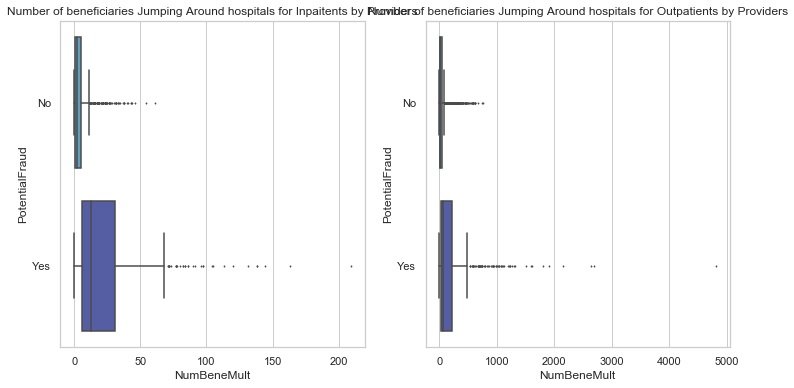

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data = num_bene[num_bene['IsOutpatient'] == 0], 
            x = "NumBeneMult", y = 'PotentialFraud', ax = ax[0], fliersize= 1);
sns.boxplot(data = num_bene[num_bene['IsOutpatient'] == 1], 
            x = "NumBeneMult", y = 'PotentialFraud', ax = ax[1], fliersize= 1);
ax[0].set_title("Number of beneficiaries Jumping Around hospitals for Inpaitents by Providers")
ax[1].set_title("Number of beneficiaries Jumping Around hospitals for Outpatients by Providers")

## Do the same providers provide both inpatient and outpatient services? 

In [93]:
# Unique providers who serve inpatients
prov_inp = patient[patient['IsOutpatient']== 0].Provider.unique().tolist()

In [94]:
# providers who provide both inpatient and outpatient services
prov_both = patient[(patient.IsOutpatient == 1) & (patient.Provider.isin(prov_inp))].Provider.tolist()

In [95]:
# Boolean column for serving both types of patients
patient.loc[patient["Provider"].isin(prov_both),"Prov_Both"] = 1
patient.loc[~patient["Provider"].isin(prov_both),"Prov_Both"] = 0

In [110]:
num_prov_both = patient.groupby(['PotentialFraud'])[['Prov_Both']].sum()

num_prov_both['length'] = \
        [patient[patient['PotentialFraud'] == "No"].shape[0],patient[patient['PotentialFraud'] == "Yes"].shape[0]]
num_prov_both['Prov_Both_Ratio'] = num_prov_both["Prov_Both"]/num_prov_both["length"]
num_prov_both

,Prov_Both,length,Prov_Both_Ratio
PotentialFraud,,,
No,121782.0,345415,0.352567
Yes,134682.0,212796,0.632916


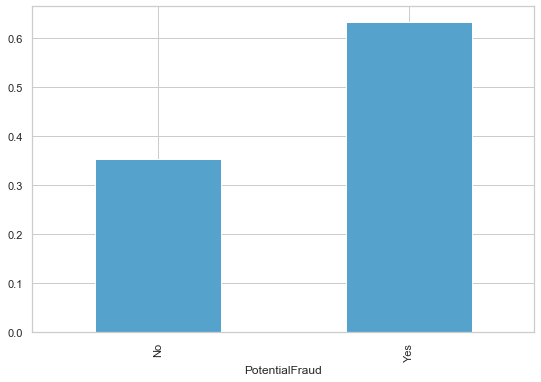

In [112]:
num_prov_both.Prov_Both_Ratio.plot(kind='bar');

## Do Some of the same patients receive both inpatient and outpatient services? 

In [114]:
# Unique beneficiaries that receive inpatient service
bene_inp = patient[patient['IsOutpatient']== 0].BeneID.unique().tolist()

In [115]:
# Beneficiaries that receive both in/out patient service
bene_both = patient[(patient['IsOutpatient'] == 1) & (patient.BeneID.isin(bene_inp))].BeneID.tolist()

In [118]:
patient.loc[patient["BeneID"].isin(bene_both),"Bene_Both"] = 1
patient.loc[~patient["BeneID"].isin(bene_both),"Bene_Both"] = 0

In [120]:
num_bene_both = patient.groupby(['PotentialFraud'])[['Bene_Both']].sum()

num_bene_both['length'] = \
        [patient[patient['PotentialFraud'] == "No"].shape[0],patient[patient['PotentialFraud'] == "Yes"].shape[0]]
num_bene_both['Bene_Both_Ratio'] = num_bene_both["Bene_Both"]/num_bene_both["length"]
num_bene_both

,Bene_Both,length,Bene_Both_Ratio
PotentialFraud,,,
No,94283.0,345415,0.272956
Yes,66599.0,212796,0.312971


Text(0, 0.5, 'dd')

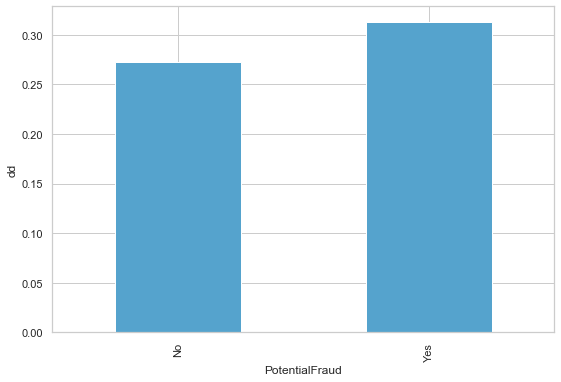

In [124]:
num_bene_both.Bene_Both_Ratio.plot(kind='bar');
plt.ylabel("")

## Study the relationship between the patient ages (at the time of their service) and the counts of medical claims.


In [135]:
from dateutil.relativedelta import relativedelta

In [153]:
patient["AgeAtClm"] = round((patient["ClaimStartDt"] - patient["DOB"]).dt.days/365,0).astype(int)

In [170]:
bene_age = patient.groupby(['PotentialFraud','AgeAtClm'])[['ClaimID']].count()
bene_age.columns.values[0] = 'Count'
bene_age = bene_age.reset_index()
bene_age

,PotentialFraud,AgeAtClm,Count
0,No,25,44
1,No,26,358
2,No,27,468
3,No,28,526
4,No,29,538
...,...,...,...
149,Yes,97,1305
150,Yes,98,1242
151,Yes,99,1238
152,Yes,100,1166


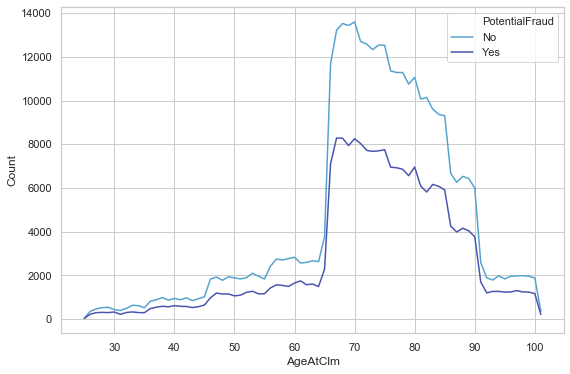

In [172]:
sns.lineplot(data = bene_age,x = "AgeAtClm", y = 'Count', hue='PotentialFraud');

In [181]:
avg_age = patient.groupby(['PotentialFraud','IsOutpatient','Provider'])[['AgeAtClm']].mean()
avg_age.columns.values[0] = 'AvgAge'
avg_age = avg_age.reset_index()
avg_age

,PotentialFraud,IsOutpatient,Provider,AvgAge
0,No,0,PRV51001,77.800000
1,No,0,PRV51007,78.000000
2,No,0,PRV51008,51.000000
3,No,0,PRV51011,98.000000
4,No,0,PRV51023,73.444444
...,...,...,...,...
7099,Yes,1,PRV57569,76.867647
7100,Yes,1,PRV57642,73.137056
7101,Yes,1,PRV57672,74.583529
7102,Yes,1,PRV57697,70.722222


Text(0.5, 1.0, 'Average Age of Outpatients by Providers')

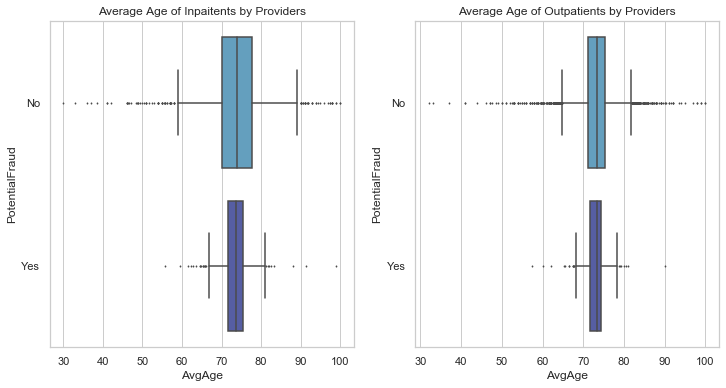

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data = avg_age[avg_age['IsOutpatient'] == 0], 
            x = "AvgAge", y = 'PotentialFraud', ax = ax[0], fliersize= 1);
sns.boxplot(data = avg_age[avg_age['IsOutpatient'] == 1], 
            x = "AvgAge", y = 'PotentialFraud', ax = ax[1], fliersize= 1);
ax[0].set_title("Average Age of Inpaitents by Providers")
ax[1].set_title("Average Age of Outpatients by Providers")

## Study the relationship between the patient age and their chornic conditions. Within the train-samples, do these chronic conditions show a definite trend with respect to increasing ages?


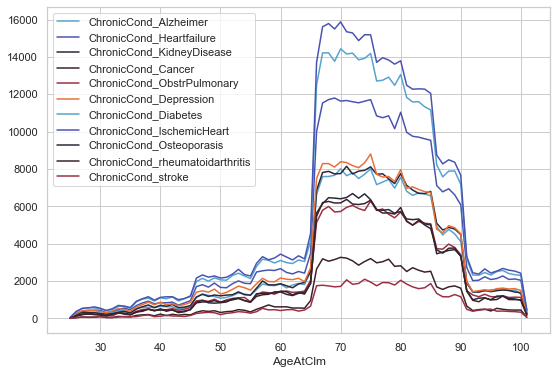

In [201]:
patient.groupby('AgeAtClm')[chronic].sum().plot(kind = 'line');

## In order to make sure the insurance premiums can cover the claims, the insurance company would need to categorize the patients according to their resource usage. In answering the question that what types of patients would make more in/outpatient visits?

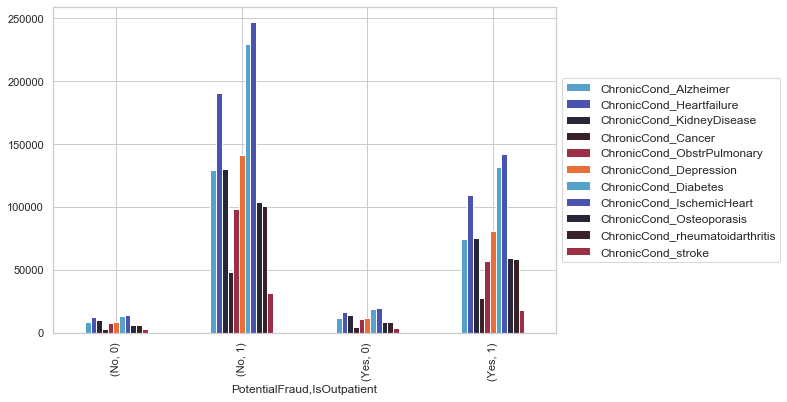

In [215]:
patient.groupby(['PotentialFraud','IsOutpatient'])[chronic].sum().plot(kind = 'bar');
plt.legend(fontsize = 12, bbox_to_anchor=(1,0.8));

## From the prospect of the insurance company, the reimbursed amounts are their coverage on the claims. Please analyze the patterns of the total reimbursed amounts (or average reimbursed amounts/visit) vs different types of patients.

## From the prospect of the providers, the sum of reimbursed amounts and deductibles are flowing to the providers. Based on this, analyze which types of patients contribute more to the providers in terms of the aggregate charges or the average charge per visit


In [251]:
patient["TotalRev"] = patient['InscClaimAmtReimbursed'] + patient['DeductibleAmtPaid']

In [258]:
print("No Potential Fraud")
for col in chronic:
    print('Mean Revenue from', col, ':', 
          round(patient[(patient[col] == 1)&(patient['PotentialFraud'] == "No")][["TotalRev"]].mean()[0],2))

No Potential Fraud
Mean Revenue from ChronicCond_Alzheimer : 926.31
Mean Revenue from ChronicCond_Heartfailure : 936.02
Mean Revenue from ChronicCond_KidneyDisease : 1136.21
Mean Revenue from ChronicCond_Cancer : 956.58
Mean Revenue from ChronicCond_ObstrPulmonary : 1074.88
Mean Revenue from ChronicCond_Depression : 853.71
Mean Revenue from ChronicCond_Diabetes : 880.61
Mean Revenue from ChronicCond_IschemicHeart : 879.87
Mean Revenue from ChronicCond_Osteoporasis : 834.89
Mean Revenue from ChronicCond_rheumatoidarthritis : 863.17
Mean Revenue from ChronicCond_stroke : 1194.84


In [257]:
print("Potential Fraud")
for col in chronic:
    print('Mean Revenue from', col, ':', 
          round(patient[(patient[col] == 1)&(patient['PotentialFraud'] == "Yes")][["TotalRev"]].mean()[0],2))

Potential Fraud
Mean Revenue from ChronicCond_Alzheimer : 1707.72
Mean Revenue from ChronicCond_Heartfailure : 1758.86
Mean Revenue from ChronicCond_KidneyDisease : 2118.92
Mean Revenue from ChronicCond_Cancer : 1872.85
Mean Revenue from ChronicCond_ObstrPulmonary : 2084.93
Mean Revenue from ChronicCond_Depression : 1604.08
Mean Revenue from ChronicCond_Diabetes : 1647.61
Mean Revenue from ChronicCond_IschemicHeart : 1652.27
Mean Revenue from ChronicCond_Osteoporasis : 1591.94
Mean Revenue from ChronicCond_rheumatoidarthritis : 1647.73
Mean Revenue from ChronicCond_stroke : 2336.44


## Based on the attribute ClaimStartDt, analyze the weekly service volume variations.


## What are the weekly patterns (weekly seasonalities) you observe for the demands on inpatient or outpatient services?


## Identify the top  5  most frequent ClmAdmitDiagnosisCodes and trace their weekly seasonalities. Display the patterns you find.


## For the inpatient patients, is there any pattern between the durations of the treatments and the patient attributes?


## For the monthly inpatient/outpatient claim counts of all the providers, please analyze the table of provider-month matrices and report any interesting findings.
